<a href="https://colab.research.google.com/github/eschwarzbeckf/forecast_prices/blob/main/cleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.api import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox as box
from scipy.stats import norm, shapiro

In [ ]:
import os

In [ ]:
csvs = os.listdir()
dfs = []
for csv in csvs:
    if csv.endswith('.csv'):
        df = pd.read_csv(csv)
        df.columns = ['Year','Month','Sales']
        dfs.append(df)

consolidated = pd.concat(dfs,axis=0)
consolidated = consolidated.sort_values(by=['Year','Month'])

In [ ]:
consolidated = consolidated.set_index(pd.date_range('2017-01-31','2025-07-31',freq='ME'))
consolidated.drop(['Year','Month'],axis=1,inplace=True)
consolidated.to_csv('consolidated.csv',encoding='utf-8')

In [166]:
from sktime.utils.plotting import plot_series, plot_correlations
from sktime.transformations.series.difference import Differencer
from sktime.forecasting.arima import StatsModelsARIMA
from sktime.split import temporal_train_test_split, SlidingWindowSplitter, ExpandingWindowSplitter
from sktime.performance_metrics.forecasting import MeanSquaredError, MeanAbsoluteError
from sktime.forecasting.model_evaluation import evaluate
from sktime.transformations.series.boxcox import LogTransformer

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='Sales'>)

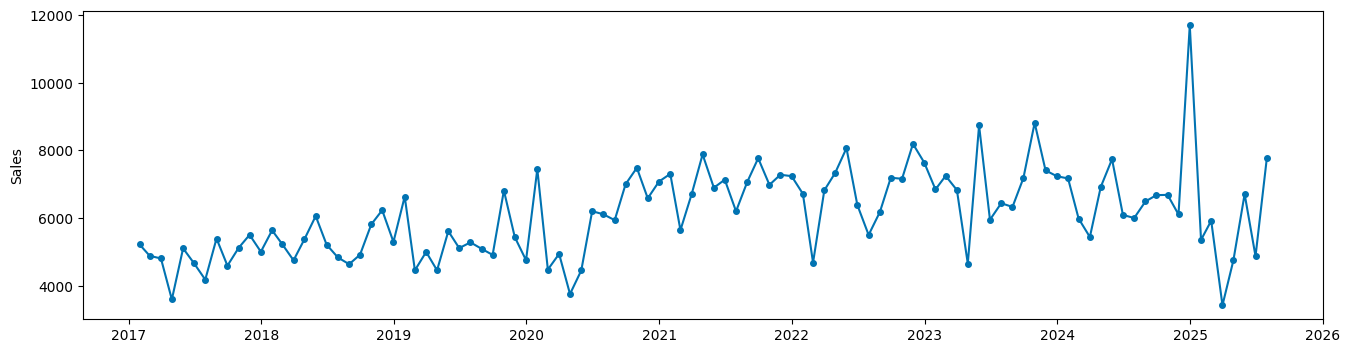

In [ ]:
plot_series(consolidated)

np.float64(0.4758927998456682)

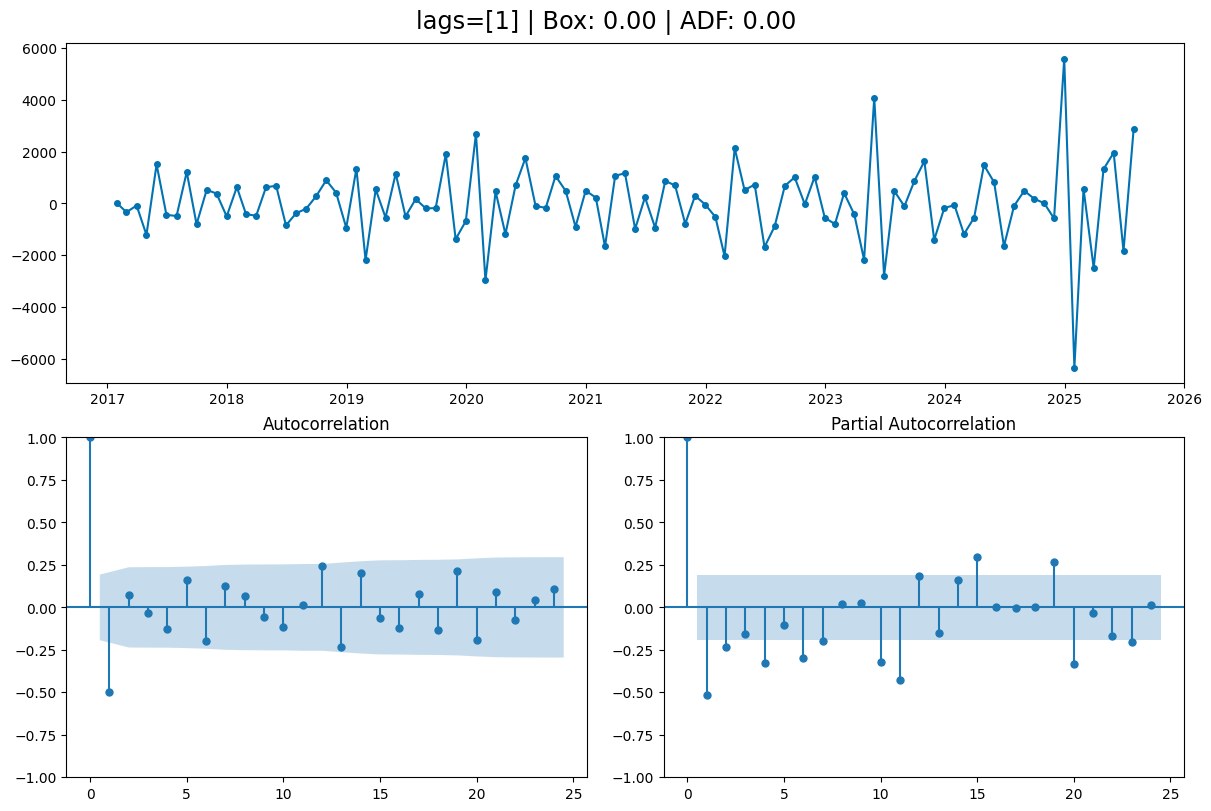

In [ ]:
lags=[1]
y = consolidated if lags == 0 else Differencer(lags=lags).fit_transform(consolidated)
plot_correlations(y,pacf_method='ols',suptitle=f"lags={lags} | Box: {box(y,lags=12)['lb_pvalue'].values[-1]:.2f} | ADF: {adfuller(y,maxlag=12)[1]:.2f}")
plt.show()

In [168]:
y_train, y_test = temporal_train_test_split(consolidated, test_size=12)
model = LogTransformer() * StatsModelsARIMA(order=(4,1,0),seasonal_order=(1,0,0,12),trend='n')
model.fit(y_train)
model.forecaster_.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                                y   No. Observations:                   91
Model:             ARIMA(4, 1, 0)x(1, 0, 0, 12)   Log Likelihood                  43.459
Date:                          Thu, 11 Sep 2025   AIC                            -74.917
Time:                                  06:18:12   BIC                            -59.919
Sample:                              01-31-2017   HQIC                           -68.869
                                   - 07-31-2024                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6539      0.106     -6.152      0.000      -0.862      -0.446
ar.L2         -0.4858      0.128     -3.799      0.000      -0.737      -0.235
ar.L3         -0.2937      0.127     -2.315      0.021      -0.542      -0.045
ar.L4         -0.2528      0.107     -2.364      0.018      -0.462      -0.043
ar.S.L12       0.3330      0.092      3.600      0.000       0.152       0.514
sigma2         0.0218      0.003      7.132      0.000       0.016       0.028
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):                 3.25
Prob(Q):                              0.74   Prob(JB):                         0.20
Heteroskedasticity (H):               1.90   Skew:                            -0.40
Prob(H) (two-sided):                  0.08   Kurtosis:                         3.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

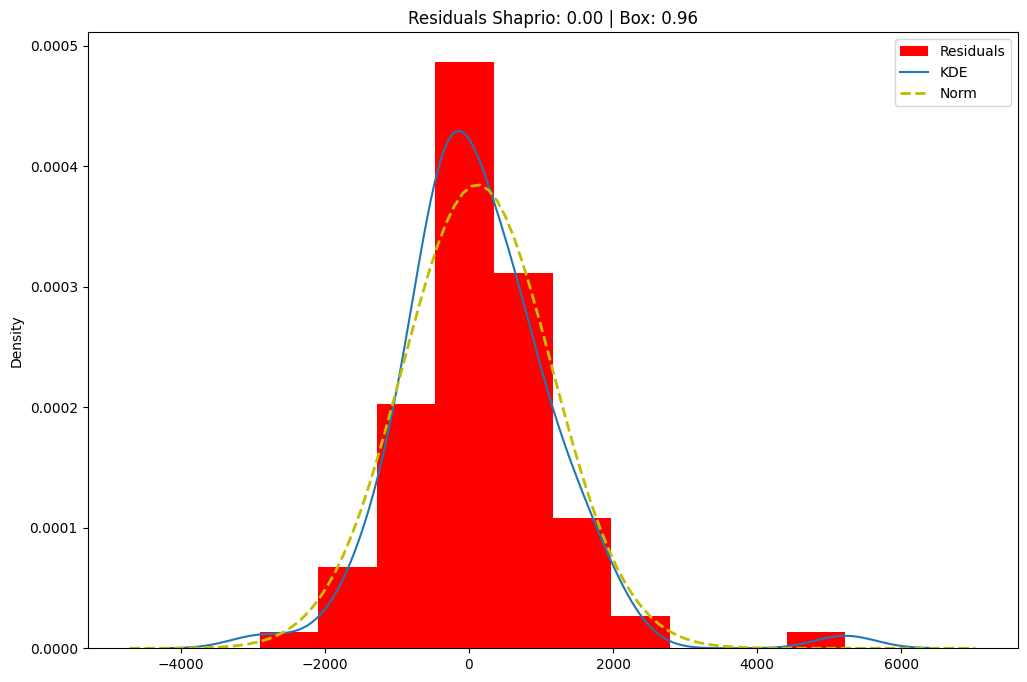

In [169]:
res = model.predict_residuals()
fig, ax = plt.subplots(figsize=(12,8))
ax.hist(res,density=True,color='red',label='Residuals')
sns.kdeplot(res,label='KDE',ax=ax)
mu, std = norm.fit(res)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
ax.plot(x, p, 'y--', linewidth=2,label='Norm')
ax.set_title(f'Residuals Shaprio: {shapiro(res)[1]:.2f} | Box: {box(res,lags=12)['lb_pvalue'].values[-1]:.2f}')
ax.legend()
plt.show()

In [156]:
mae = MeanAbsoluteError()
rmse = MeanSquaredError(square_root=True)

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['random_state']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


(<Figure size 1600x400 with 1 Axes>,
 <Axes: title={'center': "Forecast: TransformedTargetForecaster(steps=[LogTransformer(),\n                                   StatsModelsARIMA(order=(4, 1, 0),\n                                                    seasonal_order=(1, 0, 0,\n                                                                    12),\n                                                    trend='n')])\n MAE: 1280.65 | RMSE: 1886.07"}, ylabel='Sales'>)

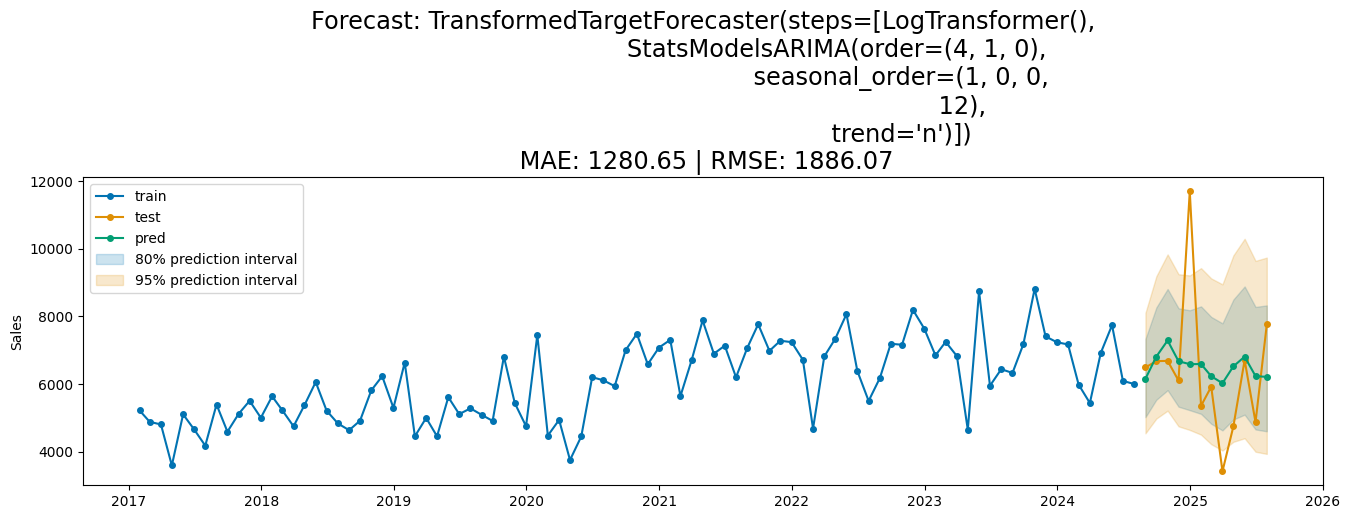

In [170]:
y_pred = model.predict(fh=y_test.index)
y_ci = model.predict_interval(fh=y_test.index, coverage=[.8,.95])
plot_series(y_train,y_test,y_hat,labels=['train','test','pred'],title=f'Forecast: {model}\n MAE: {mae.evaluate(y_test,y_pred):.2f} | RMSE: {rmse.evaluate(y_test,y_pred):.2f}',pred_interval=y_ci)

In [171]:
cv=ExpandingWindowSplitter(fh=np.arange(1,4),step_length=3,initial_window=len(consolidated)-3*4)
evaluate(model,cv=cv,y=consolidated,scoring=[mae,rmse],return_data=True)

/usr/local/lib/python3.12/dist-packages/sktime/forecasting/base/_fh.py:861: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  return r * to_offset(fh.freq)
/usr/local/lib/python3.12/dist-packages/sktime/forecasting/base/_fh.py:875: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  absolute = pd.DatetimeIndex(absolute, freq=fh.freq)
/usr/local/lib/python3.12/dist-packages/sktime/forecasting/base/_fh.py:861: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  return r * to_offset(fh.freq)
/usr/local/lib/python3.12/dist-packages/sktime/forecasting/base/_fh.py:875: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  absolute = pd.DatetimeIndex(absolute, freq=fh.freq)
/usr/local/lib/python3.12/dist-packages/sktime/forecasting/base/_fh.py:861: FutureWarning: 'M' is deprecated and will be removed

,test_MeanAbsoluteError,test_MeanSquaredError,fit_time,pred_time,len_train_window,cutoff,y_train,y_test,y_pred
0,328.527603,370.743870,0.269726,0.023035,91,2024-07-31,Sales 2017-01-31 5222.46 2017-0...,Sales 2024-08-31 6492.30 2024-0...,Sales 2024-08-31 6068.62787...
1,2273.901580,3112.785777,0.317782,0.025064,94,2024-10-31,Sales 2017-01-31 5222.46 2017-0...,Sales 2024-11-30 6106.85 2024...,Sales 2024-11-30 6541.40977...
2,1873.270313,2138.128366,0.309860,0.585591,97,2025-01-31,Sales 2017-01-31 5222.46 2017...,Sales 2025-02-28 5922.00 2025-0...,Sales 2025-02-28 6535.06476...
3,1123.773281,1563.972910,0.283202,0.022980,100,2025-04-30,Sales 2017-01-31 5222.46 2017...,Sales 2025-05-31 6708.53 2025-0...,Sales 2025-05-31 6076.80441...
